# VSOAI D class project - Aruodas.lt flats for sale

This is a project where I scraped <a href='https://www.aruodas.lt/' target='_blank'>aruodas.lt</a>, a lithuanian real estate website, for all available flat listings(ads).<br>Url for all flats: <a href='https://www.aruodas.lt/butai/' target='_blank'>https://www.aruodas.lt/butai/</a>.

Scrap was conducted on **2019-08-24**.

## 1.Obtain Data step
###  About the scraping process:

- On first, I used an aggressive strategy, where the application was used to scrap without any delays between the pages, user agent strings or from
links. I learned that from this "brute force" way, I was getting one captcha page for about 50 pages scraped.And, of course, this strategy got me banned from the website
pretty fast.
- After I learned from this mistake, I used more carefull approach, where I added delays, user agent strings and from urls and that worked like a charm.No captcha pages were displayed.

I used <a href='https://pythonhosted.org/pyquery/' target='_blank'>pyquery</a> library to help me dealing with HTML pages.

You can download web scraping python files and .csv files in here: <a href='https://drive.google.com/open?id=1LHofBx1IeoqaVPB14v-Epqw3NybZxmXd'>URL</a>.

## 2.Data cleaning step

Before adding data to a .csv file, I cleaned data a bit(in the scrap file).


<div>
    <table align="left">
      <tr>
        <th>Column name</th>
        <th>Removed whitespace</th> 
        <th>Removed symbols</th>
      </tr>
      <tr>
        <td>Price (renamed below)</td>
        <td>YES</td> 
        <td>€</td>
      </tr>
      <tr>
        <td>Pricem2 (renamed below)</td>
        <td>YES</td> 
        <td>€/m² ()</td>
      </tr>
      <tr>
          <td>Area (renamed below)</td>
          <td>NO</td>
          <td>m² ,</td>
      </tr>
      <tr>
          <td>Phone (renamed below)</td>
          <td>YES</td>
          <td>+</td>
      </tr>
      <tr>
          <td>Coords (renamed below)</td>
          <td>NO</td>
          <td>,</td>
      </tr>
    </table>
</div>

### 2nd round of cleaning:
Imports:

In [1]:
# Core imports.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Folium - to make maps.
import folium
import folium.plugins as plugins
from folium.plugins import MarkerCluster
from IPython.display import IFrame

# Helper imports.
import re # Regex
from dateutil.parser import parse

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

pd.set_option("display.max_rows", 100)
print("Setup Complete.")

Setup Complete.


#### Read .csv file
While reading csv file via ```pd.read_csv```, I set NaN values to be identified as a minus sign("-").<br> Originally in the scraper file I put not found values as "-", so here
I am making them NaN.

In [2]:
flatsSale = pd.read_csv("flatsforsale.csv", na_values=["-"])
print("Dataset read.")

Dataset read.


### Cleaning operations
```clean_text_cols``` - Cleans text columns that should not have any numerical data.<br>
*   Replaces anything that's not a letter, special lithuanian letters or '.' and ','.

```clean_misc_cols``` - Cleans columns that have both text and numerical data.
*   Replaces anything that's not a letter, special lithuanian letters, '.', ',' and digits.

```clean_telephone_col``` - Cleans a Telephone column.<br>
*   Replace incorrect value "+" with NaN.

```clean_date_cols``` - Validates dates.
*   Validates dates with YYYY-MM-DD format.

```clean_coordinates_col``` - Validate coordinates.
*   Removes extra whitespace & adds comma between two geo points.

```add_latitude_co``` - Get latitude coordinate froom Coords column.

```add_longitude_col``` - Get longitude coordinate from Coords column

```clean_year_col```- Cleans Year column.
*   Removes these strings: "1965 statyba, 2015 renovacija".<br>
Leaves only the first year - "1965".<br>Also removes years not in this range:(1800;2025)

All methods accept one row from a Series.

In [3]:
def clean_text_cols(row):
    if isinstance(row, str):
        regex = r"[^a-zA-Z \.\,\ą\ę\į\ų\ū\ė\š\ž\č\Ą\Ę\Į\Ų\Ū\Ė\Š\Ž\Č]"
        row = re.sub(regex, '', str(row))      
    return row
  
def clean_misc_cols(row):
    if isinstance(row, str):    
        regex = r"[^a-zA-Z\d \.\,\ą\ę\į\ų\ū\ė\š\ž\č\Ą\Ę\Į\Ų\Ū\Ė\Š\Ž\Č]"
        row = re.sub(regex, '', str(row))    
    return row
  
def clean_telephone_col(row):
    if row == "+":
        return np.NaN
    else:
        return row

def clean_date_cols(row):
    try:
        if isinstance(row, str):
            if parse(row):
                return np.datetime64(parse(row), "D")
    except ValueError:
        return str(row)
      
def clean_coordinates_col(row):
    if isinstance(row, str):
        index = row.find(" ")
        if index != -1:
            row = row[:index] + "," + row[index:]
            row = row.replace(" ", "")
    return row

def add_latitude_col(row):
    if isinstance(row, str):
        row = float(row[:row.find(",")])    
    return row
  
def add_longitude_col(row):
    if isinstance(row, str):
        row = float(row[row.find(",") + 1:])
    return row 
  
def clean_year_col(row):
    if isinstance(row, str):
        index = row.find("statyba")
        if index != -1:
            row = row[:index - 1]
        row = np.int64(row)    
    if row < 1600 or row > 2025:
        return np.NaN
    
    return row

Renaming columns:

In [4]:
flatsSale.rename(columns={"County": "District",
                          "Price EUR": "Price", 
                          "Price per m2": "Pricem2", 
                          "Area m2": "Area", 
                          "Flat number": "FlatNumber",
                          "House number": "HouseNumber",
                          "Total floors": "TotalFloors",
                          "Building type": "BuildingType",
                          "Installation type": "InstallationType",
                          "Extra quarters": "ExtraQuarters",
                          "Extra equipment": "ExtraEquipment",
                          "Upload date": "UploadDate",
                          "Modify date": "ModifyDate",
                          "Memorized count": "MemorizedCount",
                          "Telephone": "Phone",
                          "Coordinates": "Coords"
                         }, inplace=True)

Executing cleaning:

In [5]:
text_columns = [ "City", "District", "BuildingType", "Heating", "InstallationType" ]
misc_columns = [ "Street", "FlatNumber", "HouseNumber", "Year" ]
date_columns = [ "UploadDate", "ModifyDate" ]

for col in text_columns:
    flatsSale[col] = flatsSale[col].apply(lambda x: clean_text_cols(x))
  
for col in misc_columns:
    flatsSale[col] = flatsSale[col].apply(lambda x: clean_misc_cols(x))
  
for col in date_columns:
    flatsSale[col] = flatsSale[col].apply(lambda x: clean_date_cols(x))
 
flatsSale["Phone"] = flatsSale["Phone"].apply(lambda x: clean_telephone_col(x))
flatsSale["Coords"] = flatsSale["Coords"].apply(lambda x: clean_coordinates_col(x))
flatsSale["Latitude"] = flatsSale["Coords"].apply(lambda x: add_latitude_col(x))
flatsSale["Longitude"] = flatsSale["Coords"].apply(lambda x: add_longitude_col(x))
flatsSale["Year"] = flatsSale["Year"].apply(lambda x: clean_year_col(x))
print("Cleaning complete.")

Cleaning complete.


### Conclussions


**What I have done:**
*   Converted "-" to NaN values.
*   Renamed 16 columns to better names.
*   Cleaned columns with regex to preserve data format.

Some cleaning with individual columns:<br> (Some columns were excluded, because of no significant changes
or information regarding cleaning)

In [6]:
def highlight_greaterthan(s):
    column_name = "NaN % of total values"
    is_max = pd.Series(data=False, index=s.index)
    is_max["NaN % of total values"] = s["NaN % of total values"] >= 50
    return ['color: red;font-weight:bold' if is_max.any() else '' for v in is_max]

cleanStats = pd.DataFrame({ "Regex ran": ["No", "Yes", "Yes", "No", "No", "No", "No", "No",
                                          "No", "No", "No", "Yes", "Yes", "Yes", "Yes", "Yes",
                                          "Yes", "No", "No", "No", "No", "No", "No", "No",
                                          "No", "No", "No", "No", "No"],
                            "Number of rows converted to NaN":flatsSale.copy().isnull().sum() })

cleanStats.index.name = "Column name"
cleanStats["NaN % of total values" ] = round((cleanStats["Number of rows converted to NaN"] / 9687) * 100, 5)
cleanStats = cleanStats[cleanStats["Number of rows converted to NaN"] > 0]
cleanStats.style.apply(highlight_greaterthan, axis=1)

,Regex ran,Number of rows converted to NaN,NaN % of total values
Column name,,,
District,Yes,1599,16.5067
Street,Yes,2,0.02065
HouseCount,No,7031,72.5818
FlatNumber,Yes,8575,88.5207
HouseNumber,Yes,5595,57.7578
Year,Yes,26,0.2684
BuildingType,Yes,1,0.01032
InstallationType,Yes,1,0.01032
Specials,No,4737,48.9006


From the table above, because NaN values are occupying more than 50% in these columns, <br> I am going to remove these columns:<br>

*    **HouseCount**
*    **FlatNumber**
*    **HouseNumber**
*    **ExtraQuarters**
*    **ExtraEquipment**
*    **Security**
*    **Coords** (removed because it no longer serves it's purpose).

In [7]:
flatsSale.drop(["HouseCount", "FlatNumber", "FlatNumber", "HouseNumber", 
                "ExtraQuarters", "ExtraEquipment", "Security","Coords"], axis=1, inplace=True)

## 3.Explore data

First, we'll start by describing each column.

<b>Flat location:</b><br>
<div>
    <table align="left">
      <tr>
        <th>Column name</th>
        <th>Description</th>
      </tr>
      <tr>
        <td>City</td>
        <td>Flat's city/district/region.</td> 
        <td>
      </tr>
      <tr>
        <td>District</td>
        <td>Flat's district (smaller location unit).</td> 
        <td>
      </tr>            
      <tr>
        <td>Street</td>
        <td>Street name.</td> 
      </tr>
      <tr>
          <td>Latitude</td>
          <td>Flat's latitude coordinate.</td>
      </tr>
      <tr>
          <td>Longitude</td>
          <td>Flat's longitude coordinate.</td>
      </tr>              
    </table>
</div>
<br><br><br>
<br><br><br>
<br><br><br>
<b>Flat price:</b><br>
<div>
    <table align="left">
      <tr>
        <th>Column name</th>
        <th>Description</th>
      </tr>
      <tr>
          <td>Price</td>
          <td>Flat's price in EUR.</td>
      </tr>
      <tr>
          <td>Pricem2</td>
          <td>Flat's price per square metre(m2).</td>
      </tr>
    </table>
</div>
<br><br><br>
<br><br>
<b>Flat contact:</b><br>
<div>
    <table align="left">
      <tr>
        <th>Column name</th>
        <th>Description</th>
      </tr>
      <tr>
          <td>Link</td>
          <td>Ad's url.</td>
      </tr>
      <tr>
          <td>Phone</td>
          <td>Flat's owner phone number.</td>
      </tr>   
    </table>
</div>
<br><br><br>
<br><br> 
<b>Flat statistics:</b><br>
<div>
    <table align="left">
      <tr>
          <td>MemorizedCount</td>
          <td>Counter of how many people saved the ad.</td>
      </tr>      
       <tr>
          <td>Views</td>
          <td>View count of the ad.</td>
      </tr> 
      <tr>
          <td>UploadDate</td>
          <td>Upload date of the ad.Format: YYYY-MM-DD</td>
      </tr>      
      <tr>
          <td>ModifyDate</td>
          <td>Modify date of the ad.Format: YYYY-MM-DD</td>
      </tr>          
    </table>
</div>
<br><br><br>
<br><br><br>  
<b>Flat general:</b><br>
<div>
    <table align="left">     
     <tr>
          <td>Rooms</td>
          <td>Flat's total room count.</td>
      </tr>      
      <tr>
          <td>Area</td>
          <td>Flat's area in square metres(m2).</td>
      </tr>      
      <tr>
          <td>Floor</td>
          <td>Flat's floor number in a building.</td>
      </tr>      
      <tr>
          <td>TotalFloors</td>
          <td>Total floors in a flat's building.</td>
      </tr>      
      <tr>
          <td>HouseNumber (removed)</td>
          <td>(Removed) Flat's house number</td>
      </tr>
      <tr>
          <td>FlatNumber (removed)</td>
          <td>(Removed) Flat's number in a building.</td>
      </tr>
      <tr>
          <td>Year</td>
          <td>Flat's building construction date, format: YYYY.</td>
      </tr>      
      <tr>
          <td>BuildingType</td>
          <td>Building type.</td>
      </tr>      
      <tr>
          <td>Heating</td>
          <td>Heating type.</td>
      </tr>      
      <tr>
          <td>InstallationType</td>
          <td>Finishing type.</td>
      </tr>              
    </table>
</div>

<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
<br>
<b>Flat detail info:</b><br>
<div>
    <table align="left">         
     <tr>
          <td>Specials</td>
          <td>Special items that describe a flat, e.g: flat can have new plumbing.</td>
      </tr>     
      <tr>
          <td>ExtraQuarters</td>
          <td>Special rooms that a flat has, e.g: flat can have a balcony.</td>
      </tr>      
      <tr>
          <td>ExtraEquipment</td>
          <td>Equipment that come with a flat, e.g: dishwasher.</td>
      </tr>      
      <tr>
          <td>Security</td>
          <td>Describes the security meassures that a particular flat employs, e.g: alarm</td>
      </tr>              
    </table>
</div>

### Dataframe description (of numeric columns):

In [8]:
flatsSale.describe()

,Price,Pricem2,Rooms,Area,Floor,TotalFloors,Year,MemorizedCount,Views,Latitude,Longitude
count,9.687000e+03,9687.000000,9687.000000,9687.000000,9687.000000,9687.000000,9661.000000,8239.000000,9687.000000,6818.000000,6818.000000
mean,8.932581e+04,1385.707133,2.485702,61.142401,3.209766,5.205223,1988.356278,8.996723,1607.112315,55.135585,23.766287
std,9.845055e+04,852.489080,1.516506,42.387028,2.430699,3.434831,27.132986,11.433463,2854.692687,0.541535,1.636856
min,3.500000e+02,8.000000,1.000000,2.680000,0.000000,1.000000,1670.000000,1.000000,4.000000,54.000638,20.984907
25%,4.250000e+04,842.000000,2.000000,44.000000,2.000000,3.000000,1972.000000,2.000000,312.000000,54.698751,22.326820
50%,6.600000e+04,1191.000000,2.000000,55.100000,3.000000,5.000000,1989.000000,5.000000,782.000000,54.907141,23.986534
75%,1.030000e+05,1708.000000,3.000000,71.500000,4.000000,5.000000,2015.000000,11.000000,1783.000000,55.696285,25.262771
max,1.849000e+06,9386.000000,116.000000,2989.020000,33.000000,50.000000,2021.000000,142.000000,70676.000000,56.364013,26.675958


From the table above, I can make some observations(I encourage you to make some by yourself):

**Price:**
*   Cheapest flat: 350 EUR (about 1 minimum wage): <a href='https://www.aruodas.lt/butai-radviliskyje-baisogalos-mstl-grinkiskio-g-vi-turto-bankas-im-k-112021042-buveine-1-2753551/' target='_blank'>URL</a>
*   Most expensive flat: 1 849 000 EUR or 5282 cheapest flats: <a target=' https://www.aruodas.lt/butai-vilniuje-senamiestyje-siauliu-g-parduodami-isskirtiniai-apartamentai-1-2754935/' target='_blank'>URL</a>
*   Average price: ‭89,325.81‬ EUR.<br>
That means that:
with downpayment of 20% (‭17,865.162‬ EUR),<br>
and with **500 EUR**(interest + monthly payment) payment,<br> one would need ‭142.921296‬ months or about **12** years to fully pay for a average flat.

**Rooms:**
*  Average rooms per flat is a bit about 2.5 rooms!

**Floor:**
*  Lowest flat is located on 0 floor(basement?!?): <a href='https://www.aruodas.lt/butai-vilniuje-naujamiestyje-a-gostauto-g-isskirtinis-butas-patalpos-centre-1-2772139/' target='_blank'>URL</a>
*  Highest flat is located on 33th floor:
 <a href='https://www.aruodas.lt/butai-klaipedoje-centre-kuosu-g-kuosu-gatveje-parduodamas-2-ju-kambariu-butas-1-2744623/' target='_blank'>URL</a>


**TotalFloors:**
* Highest building has 50 floors, that's a skyscraper!<br>
* Average height of a flat building is a bit above 5 floors. <br> That was expected, since you can go visit Žirmūnai or Šnipiškės in Vilnius or any other Vilnius district and you'll find by yourself.

**Year:**
* Oldest valid flat is in Vilnius Senamiestis: <a href='https://www.aruodas.lt/butai-vilniuje-senamiestyje-pilies-g-parduodama-158-kvm-prabangus-apartamentai-1-2757417/' target='_blank'>URL</a>
* Future flat is here: <a href='https://www.aruodas.lt/butai-vilniuje-senamiestyje-zygimantu-g-zygimantu-12-namai-miesto-gyvenimo-1-2771125/' target='_blank'>URL</a>


**MemorizedCount**
*   Most memorized ad is:
 <a href='https://www.aruodas.lt/butai-vilniuje-zveryne-miglos-g-parduodamas-butas-karoliniskiu-draustinyje-1-2727927/' target='_blank'>URL</a> <br>
Price for this flat is way below average, so maybe people memorize ads those prices are below the market ones?

**Views:**
*   Most viewed ad is: <a href='https://www.aruodas.lt/butai-vilniuje-pasilaiciuose-eitminu-g-3-asis-eitminu-namai-etapas-salia-irengta-1-1869374/' target='_blank'>URL</a>


**Phone:**
*  The best realtors, or the most active ones here(TOP-10):<br>
<br>
<div>
    <table align="left">
      <tr>
        <th>Realtor's phone number</th>
        <th>Realtor's agency name</th>  
        <th>Frequency</th>
      </tr>
      <tr>
        <td>37065593900</td>
        <td>Akorus Real Estate</td> 
        <td>74</td>
      </tr>
      <tr>
        <td>37068755595</td>
        <td>Rebaltc</td> 
        <td>49</td>
      </tr>            
      <tr>
        <td>852112711</td>
        <td>Vilnius municipality's public auctions</td> 
        <td>47</td>          
      </tr>
      <tr>
        <td>37067419090</td>
        <td>WEST CITY</td>
        <td>45</td>          
      </tr>
      <tr>
        <td>37060886551</td>
        <td>Kurorto nekilnojamasis turtas</td>
        <td>44</td>          
      </tr>
      <tr>
        <td>37064767242</td>
        <td>JURGITA JONAITYTĖ</td> 
        <td>41</td>
      </tr>
      <tr>
        <td>37069998676</td>
        <td>Capital</td> 
        <td>41</td>
      </tr>            
      <tr>
        <td>37064892454</td>
        <td>NT pulsas</td> 
        <td>37</td>          
      </tr>
      <tr>
        <td>37065744365</td>
        <td>Rebaltic</td>
        <td>36</td>          
      </tr>
      <tr>
        <td>37061855656</td>
        <td>Capital</td>
        <td>33</td>          
      </tr>              
    </table>
</div> 

**General:**
*   Both the max rooms(116!) and max area is from the same ad:<a href='https://www.aruodas.lt/butai-visagine-festivalio-g-vi-turto-bankas-im-k-112021042-buveine-1-2729839/' target='_blank'>url</a>
    
*   Most viewed ad and the most memorized one(MemorizedCount) are not for the same ad!


#### Links/data for information above:

In [9]:
print("\033[1m" + "Price:" + "\033[0m")
print("Cheapest flat: ", flatsSale[flatsSale["Price"] == 350]["Link"].iloc[0])
print("Most expensive flat: ", flatsSale[flatsSale["Price"] == 1849000]["Link"].iloc[0])

print("\033[1m" + "Floor:" + "\033[0m")
print("Lowest flat link: ", flatsSale[flatsSale['Floor'] == 0]["Link"].iloc[0])
print("Highest flat link: ", flatsSale[flatsSale["Floor"] == 33]["Link"].iloc[0])

print("\033[1m" +"TotalFloors:" + "\033[0m")
print("Highest building: ", flatsSale[flatsSale["TotalFloors"] == 50]["Link"].iloc[0])

print("\033[1m" + "Year:" + "\033[0m")
print("Oldest valid flat: ", flatsSale[flatsSale["Year"] == 1683]["Link"].iloc[0])
print("Youngest(Future) flat: ", flatsSale[flatsSale["Year"] == 2021]["Link"].iloc[0])

print("\033[1m" + "MemorizedCount:" + "\033[0m")
print("Most memorized flat link: ", flatsSale[flatsSale["MemorizedCount"] == 142]["Link"].iloc[0])

print("\033[1m" + "Views:" + "\033[0m")
print("Most viewed flat: ", flatsSale[flatsSale["MemorizedCount"] == 142]["Link"].iloc[0])

print("\033[1m" + "Phone:" + "\033[0m")
print("TOP-10 real estate agents:", flatsSale.groupby("Phone").size().sort_values(ascending=False)[:10])

print("\033[1m" + "General:" + "\033[0m")
print("Max rooms: ", flatsSale[flatsSale["Rooms"] == 116]["Link"].iloc[0])

Price:
Cheapest flat:  https://www.aruodas.lt/butai-radviliskyje-baisogalos-mstl-grinkiskio-g-vi-turto-bankas-im-k-112021042-buveine-1-2753551/
Most expensive flat:  https://www.aruodas.lt/butai-vilniuje-senamiestyje-siauliu-g-parduodami-isskirtiniai-apartamentai-1-2754935/
Floor:
Lowest flat link:  https://www.aruodas.lt/butai-vilniuje-naujamiestyje-a-gostauto-g-isskirtinis-butas-patalpos-centre-1-2772139/
Highest flat link:  https://www.aruodas.lt/butai-klaipedoje-centre-kuosu-g-kuosu-gatveje-parduodamas-2-ju-kambariu-butas-1-2744623/
TotalFloors:
Highest building:  https://www.aruodas.lt/butai-vilniuje-naujamiestyje-svitrigailos-g--butas-vertinamoje-naujamiescio-dalyje-1-2765423/
Year:
Oldest valid flat:  https://www.aruodas.lt/butai-vilniuje-senamiestyje-pilies-g-parduodama-158-kvm-prabangus-apartamentai-1-2757417/
Youngest(Future) flat:  https://www.aruodas.lt/butai-vilniuje-senamiestyje-zygimantu-g-zygimantu-12-namai-miesto-gyvenimo-1-2771125/
MemorizedCount:
Most memorized flat 

### Unique values in columns
Not all columns provided because of size.<br>
Feel free to experiment yourself.

#### City column (big list):

In [10]:
print(flatsSale["City"].unique())

['Vilnius' 'Kaunas' 'Klaipėda' 'Kauno r. sav.' 'Neringos m.' 'Palanga'
 'Kėdainių r. sav.' 'Kėdainių m.' 'Marijampolės m.' 'Druskininkų m.'
 'Šiauliai' 'Molėtų m.' 'Mažeikių m.' 'Kretingos m.' 'Plungės m.'
 'Švenčionių r. sav.' 'Vilniaus r. sav.' 'Radviliškio m.' 'Panevėžys'
 'Biržų m.' 'Trakų r. sav.' 'Druskininkų sav.' 'Akmenės r. sav.' 'Alytus'
 'Raseinių r. sav.' 'Ukmergės m.' 'Varėnos m.' 'Kaišiadorių m.'
 'Zarasų r. sav.' 'Kretingos r. sav.' 'Klaipėdos r. sav.' 'Tauragės m.'
 'Kaišiadorių r. sav.' 'Širvintų r. sav.' 'Biržų r. sav.' 'Jonavos m.'
 'Visagino m.' 'Joniškio m.' 'Radviliškio r. sav.' 'Utenos m.' 'Kelmės m.'
 'Anykščių m.' 'Ukmergės r. sav.' 'Rietavo m.' 'Birštono m.' 'Telšių m.'
 'Lazdijų r. sav.' 'Šilutės r. sav.' 'Pasvalio m.' 'Rietavo sav.'
 'Skuodo r. sav.' 'Telšių r. sav.' 'Širvintų m.' 'Elektrėnų m.'
 'Jurbarko m.' 'Kazlų Rūdos m.' 'Šalčininkų m.' 'Šalčininkų r. sav.'
 'Jonavos r. sav.' 'Tauragės r. sav.' 'Elektrėnų sav.' 'Šilutės m.'
 'Panevėžio r. sav.' 'Rasein

#### Building types:

In [11]:
print(flatsSale["BuildingType"].dropna().unique())

['Mūrinis' 'Blokinis' 'Kita' 'Monolitinis' 'Karkasinis' 'Medinis'
 'Rąstinis']


#### Districts (big list):

In [12]:
print(flatsSale["District"].dropna().unique())

[' Visoriai' ' Pilaitė' ' Burbiškės' ' Antakalnis' ' Šnipiškės'
 ' Naujamiestis' ' Pašilaičiai' ' Bajorai' ' Viršuliškės' ' Dainava'
 ' Žaliakalnis' ' Žemutiniai Kaniūkai' ' Šilainiai' ' Aleksotas'
 ' Šauliai' ' Mažasis kaimelis' ' Romainiai' ' Užliedžių k.'
 ' Ražiškių k.' ' Markučiai' ' Varpai' ' Lampėdžiai' ' Užupis'
 ' Baltupiai' ' Šeškinė' ' Gudžiūnų mstl.' ' Jeruzalė' ' Senamiestis'
 ' Šventoji' ' Lazdynėliai' ' Lazdynai' ' Vilijampolė' ' Tarandė'
 ' Centras' ' Balsiai' ' Degučiai' ' Saulėtekis' ' Aukštieji Šančiai'
 ' Naujininkai' ' Karoliniškės' ' Valakampiai' ' Verkiai' ' Freda'
 ' Lančiūnavos k.' ' Žirmūnai' ' Pelėdnagių k.' ' Giraitės k.' ' Žvėrynas'
 ' Vilainių k.' ' Kalnėnai' ' Žvejybos uostas' ' Fabijoniškės'
 ' Lieporiai' ' Eiguliai' ' Petrašiūnai' ' Švenčionėlių m.' ' Panemunė'
 ' Naujoji Vilnia' ' Pavilnys' ' Kaunas' ' Verduliai' ' Justiniškės'
 ' Bandužiai' ' Miškas' ' Klevinės vs.' ' Avižieniai' ' Alksnynė'
 ' Šiaurės miestelis' ' Melnragė' ' Poilsis' ' Rėkyva' ' Kul

#### Rooms

In [13]:
print(flatsSale["Rooms"].unique().tolist())

[2, 3, 1, 4, 7, 5, 15, 6, 8, 10, 11, 116]


#### Year

In [14]:
sa = flatsSale["Year"].sort_values(ascending=True).unique().tolist()
print(sa)

[1670.0, 1683.0, 1800.0, 1809.0, 1850.0, 1852.0, 1860.0, 1867.0, 1870.0, 1872.0, 1880.0, 1882.0, 1883.0, 1885.0, 1886.0, 1888.0, 1889.0, 1890.0, 1891.0, 1892.0, 1894.0, 1896.0, 1897.0, 1898.0, 1899.0, 1900.0, 1901.0, 1902.0, 1903.0, 1904.0, 1905.0, 1907.0, 1908.0, 1909.0, 1910.0, 1911.0, 1912.0, 1913.0, 1914.0, 1915.0, 1916.0, 1917.0, 1918.0, 1919.0, 1920.0, 1921.0, 1922.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1942.0, 1943.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0,

### Correlation

In [15]:
def color_style_red(val):
    """
    Takes a scalar and returns a string with
    the css property.
    """
    color = None
    if val > 0.2 and val <= 0.5:
        color = "#FF9987"
    elif val > 0.5 and val <= 0.7:
        color = "#FF7456"
    elif val > 0.7 and val < 1:
        color = "#FF5334"
    elif val == 1:
        color = "black"
        
    return "color: %s" % color

correlation = flatsSale[flatsSale.columns[:23]].corr(method="pearson")
correlation.style.applymap(color_style_red)

,Price,Pricem2,Rooms,Area,Floor,TotalFloors,Year,MemorizedCount,Views,Latitude,Longitude
Price,1,0.736312,0.28078,0.479501,0.135435,0.0953174,0.158057,0.00252341,-0.0118711,-0.240044,0.190725
Pricem2,0.736312,1,0.0392856,0.127329,0.0467791,0.0718871,0.27134,0.0895439,-0.0143228,-0.298895,0.185137
Rooms,0.28078,0.0392856,1,0.898707,-0.00848492,-0.0140044,0.0436046,-0.0250268,-0.0142134,-0.0400878,0.0612007
Area,0.479501,0.127329,0.898707,1,0.0530737,0.041019,0.0599351,-0.0482328,-0.0203894,-0.0648202,0.0784683
Floor,0.135435,0.0467791,-0.00848492,0.0530737,1,0.680559,0.103907,-0.0135847,-0.0200233,-0.0131565,-0.0169555
TotalFloors,0.0953174,0.0718871,-0.0140044,0.041019,0.680559,1,0.210779,-0.0131083,-0.0438194,-0.0292046,-0.0245724
Year,0.158057,0.27134,0.0436046,0.0599351,0.103907,0.210779,1,-0.0129993,-0.0414964,-0.0963175,0.0312933
MemorizedCount,0.00252341,0.0895439,-0.0250268,-0.0482328,-0.0135847,-0.0131083,-0.0129993,1,0.417306,-0.222577,0.214501
Views,-0.0118711,-0.0143228,-0.0142134,-0.0203894,-0.0200233,-0.0438194,-0.0414964,0.417306,1,-0.0508142,0.052572
Latitude,-0.240044,-0.298895,-0.0400878,-0.0648202,-0.0131565,-0.0292046,-0.0963175,-0.222577,-0.0508142,1,-0.752212


**You can tell a few things from the correlation data:**
*   Price column:
    *   I'm ignoring the relationship between Price & Pricem2, because it's trivial.
    *   A weak positive correlation between Price and Rooms (0.28078), logic being that as the larger the flat,
        the bigger the price
    *   A weak-modest positive correlation between Price and Area (0.479501), same logic as the last one.
    
*   Rooms column:   
    *   I'm yet again ignoring the relationship between Rooms & Area.
*   Views column:
    *   A bit more interesting relationship between Views & MemorizedCount (0.417306), as more people click on an add, they're more likier     to memorize that listing, but the surprising thing here is that correlation is not that strong.

As we all know, correlation shows only linear relationship, so no complex ones can be seen.<br>
Correlation strength source: https://lt.wikipedia.org/wiki/Koreliacija

### Charts
#### Helper functions:
```display_values``` - Display numeric values in a chart.
<br><br>
<div>
    <table align="left">
      <tr>
        <th>Parameter name:</th>
        <th>Description:</th>
      </tr>
      <tr>
        <td>ch</td>
        <td>Chart instance to apply to.</td> 
      </tr>
    </table>
</div>
<br><br><br>

```rotate_labels``` - Rotate X axis labels by Y degrees.It also sets the font-size for the labels.<br><br>
<div>
    <table align="left">
      <tr>
        <th>Parameter name:</th>
        <th>Description:</th>
      </tr>
      <tr>
        <td>rot</td>
        <td>Number of degrees to rotate.</td> 
      </tr>
    </table>
</div>
<br><br><br>

```init_chart``` - Method that initialzies a chart.
<br><br>
<div>
    <table align="left">
      <tr>
        <th>Parameter name:</th>
        <th>Description:</th>
      </tr>
      <tr>
        <td>chartType</td>
        <td>Chart type to initialize.Currently there are a bar, linear, pie charts.</td> 
      </tr>
      <tr>
        <td>data</td>
        <td>DataFrame data to apply on chart.</td> 
      </tr>        
      <tr>
        <td>title</td>
        <td>Title to append to a chart.</td> 
      </tr>         
      <tr>
        <td>axisLabels</td>
        <td>XY axis labels to write into a chart.</td> 
      </tr>
      <tr>
        <td>plotLabel</td>
        <td>(Optional) label to add to a chart for legend.</td> 
      </tr>        
      <tr>
        <td>lineChartData</td>
        <td>(Optional) data, that is only used for line chart initialization.</td> 
      </tr>           
    </table>
</div>
<br><br><br>
<br><br><br>
<br><br><br>
<br>

```set_value_label_color_pie``` - Sets color for all value labels in a pie chart.
<br><br>
<div>
    <table align="left">
      <tr>
        <th>Parameter name:</th>
        <th>Description:</th>
      </tr>
      <tr>
        <td>at</td>
        <td>Autotexts object of a chart.</td> 
      </tr>
      <tr>
        <td>color</td>
        <td>Color to apply.</td> 
      </tr>               
    </table>
</div>

In [16]:
#sns.set(font_scale=1.1)

def display_values(ch):
    for p in ch.patches:
             ch.annotate("%.1f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=11, color="black", xytext=(0, 8),
                 textcoords="offset points")
            
def rotate_labels(rot):
    x = plt.gca().xaxis
    for item in x.get_ticklabels():
        item.set_rotation(rot)
        item.set_fontsize(11)

def init_chart(chartType, data, title, axisLabels, plotLabel=None, lineChartData=None, bar2ChartData=None):    
    plot = None
    titleSize = 25
    if chartType == "bar":
        plot = sns.barplot(x=data.index, y=data, palette="Blues_r", label=plotLabel)
    elif chartType == "bar2":
        plot = sns.barplot(x=bar2ChartData[0], y=bar2ChartData[1], data=data, order=data[bar2ChartData[0]], palette="Blues_r", label=plotLabel)        
    elif chartType == "line":
        plot = sns.lineplot(data=data, marker=lineChartData[0], markersize=8, color=lineChartData[1], label=plotLabel, sort=False)
    elif chartType == "pie":
        plot = plt.pie(data.values.tolist(), labels=data.index, autopct="%1.1f%%", shadow=True, startangle=140, radius=1.5, textprops={"fontsize": 14})

    if plot != None and chartType != "pie":
        plot.set(xlabel = axisLabels[0], ylabel = axisLabels[1])  
        
        ylabels = ["{:,.3f}".format(x).replace(",", " ") for x in plot.get_yticks()]
        plot.set_yticklabels(ylabels, fontsize=12)    
        
        plot.xaxis.label.set_size(14)
        plot.yaxis.label.set_size(14)
        plot.xaxis.labelpad = 15
        plot.yaxis.labelpad = 15
         
    if chartType == "pie":
        titleSize = 50
    # Plot title
    plt.title(title, pad=titleSize, fontsize=14)
    # Remove Top and Right frames.
    sns.despine()
    plt.margins(0.1)
    plt.subplots_adjust(bottom=0.15)            
        
    return plot

def set_value_label_color_pie(at, color):
    for autotext in at:
        autotext.set_color(color)    

### Location

#### TOP-10 cities/districts by most flats

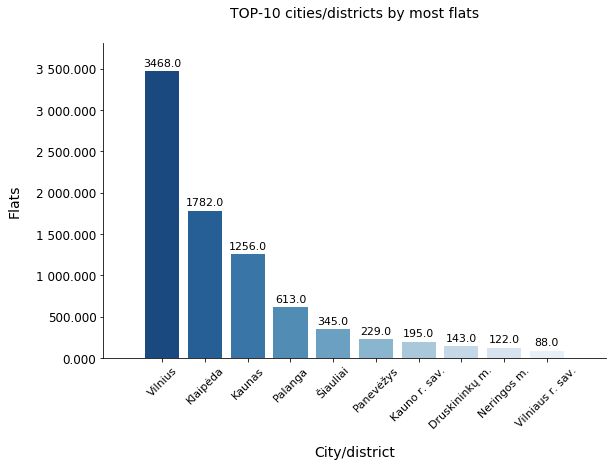

In [17]:
plt.figure(figsize = (9, 6))
top10Cities = flatsSale.groupby("City").size().sort_values(ascending=False)[:10]

plot = init_chart("bar", top10Cities, "TOP-10 cities/districts by most flats", ["City/district", "Flats"])

display_values(plot)  
rotate_labels(45)

#### Facts that we can take from the chart above:


*   Vilnius has the biggest supply for flats.
*   Klaipėda is 2nd, but number drops about **1.9** times.
*   Kaunas is 3rd, number drops about **2.7** times.


#### TOP-10 most popular streets in cities by flats

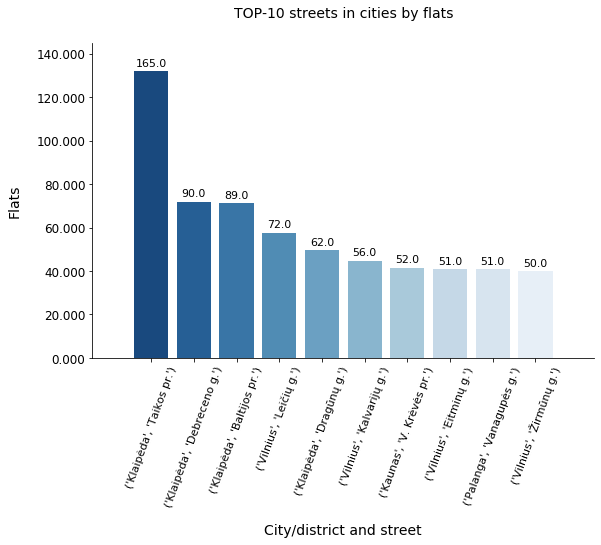

In [18]:
plt.figure(figsize = (9, 6))
top10Streets = flatsSale.groupby(["City", "Street"]).size().sort_values(ascending=False)[:10]
plot = init_chart("bar", top10Streets, "TOP-10 streets in cities by flats", 
                  ["City/district and street", "Flats"])

display_values(plot)  
rotate_labels(70)

#### Facts that we can take from the chart above:
*   Klaipėda rules with the most flats in their streets.<br>That is pretty logical, since Klaipėda is about 110 km2, while, e.g Vilnius is 401 km2, and so it's 3.6 smaller and thus the flats that people sell are more packed/located closer to each other in Klaipėda.
*   Finally, on 4th place there is Vilnius, with Leičių g. in a infamous Perkūnkiemis<br> district, which is known for the construction boom it's currently experiencing.

Out of TOP-10:
*   4 are located in Klaipėda.
*   4 are located in Vilnius.
*   1 is located in Kaunas.
*   1 is located in Palanga. 

#### TOP-10 most popular disticts in cities by flats

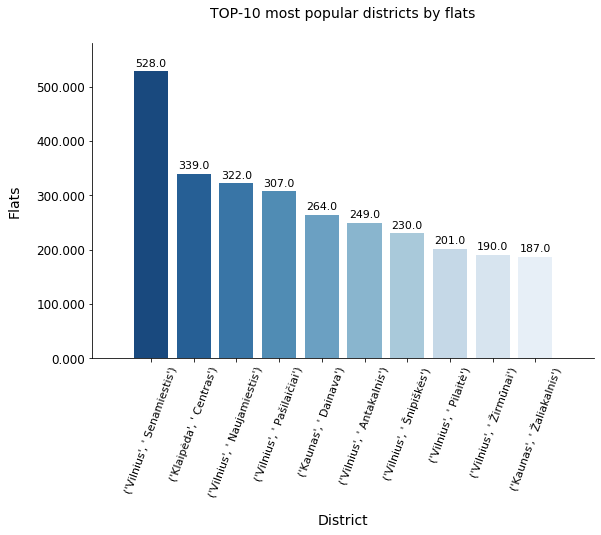

In [19]:
plt.figure(figsize = (9, 6))
top10Streets = flatsSale.groupby(["City", "District"]).size().sort_values(ascending=False)[:10]
plot = init_chart("bar", top10Streets, "TOP-10 most popular districts by flats", 
                  ["District", "Flats"])

display_values(plot)  
rotate_labels(70)

#### Facts that we can take from the chart above:
*   Most flats, that are listed, are located in Vilnius Senamiestis.<br>
*   Most districts in Vilnius, except for Pašilaičiai and Pilaitė, are located are located around city centre - Senamiestis.
*   Two districts in Vilnius that too is in this list are Pašilaičiai** and Pilaitė, who are pretty new districts, so the space is available, hence the flats for sale.
*   Most districts, that have most flats, are located in Vilnius.
*   2 districts are located in Kaunas.
*   1 is located in Klaipėda.

### Price

#### I think that Vilnius Senamiestis is a more expensive(on average) place to buy a flat than a Klaipėda Senamiestis and Kaunas Senamiestis.

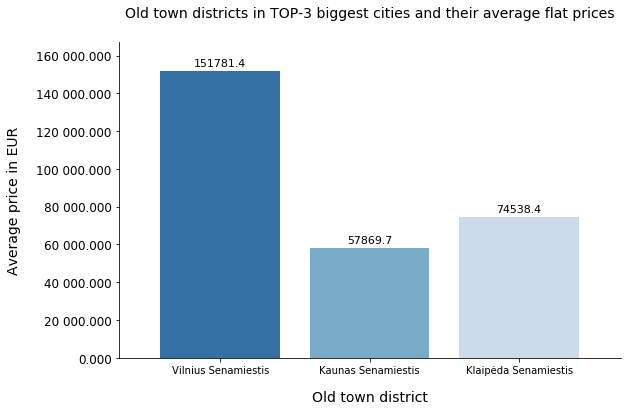

In [20]:
cities = flatsSale.groupby(["City", "District"]).mean()

vilniusOldTownPrice = cities.loc["Vilnius"]["Price"]["District" == "Senamiestis"]
kaunasOldTownPrice = cities.loc["Kaunas"]["Price"]["District" == "Senamiestis"]
klaipedaOldTownPrice = cities.loc["Klaipėda"]["Price"]["District" == "Senamiestis"]

oldtownData = pd.Series({"Vilnius Senamiestis": vilniusOldTownPrice,
                         "Kaunas Senamiestis": kaunasOldTownPrice,
                         "Klaipėda Senamiestis": klaipedaOldTownPrice})

plt.figure(figsize = (9, 6))
plot = init_chart("bar", oldtownData, "Old town districts in TOP-3 biggest cities and their average flat prices", 
                  ["Old town district", "Average price in EUR"])

display_values(plot)

#### Conclusions:
*    I was right, not only Vilnius is the most expensive city to buy a flat in Senamiestis, but the difference is so huge,
        that even if you combine the prices of Kaunas Senamiestis and Klaipėda Senamiestis, you wouldn't get the number of Vilnius Senamiestis.

### TOP-10 largest cities by population and their average flat prices and flat numbers

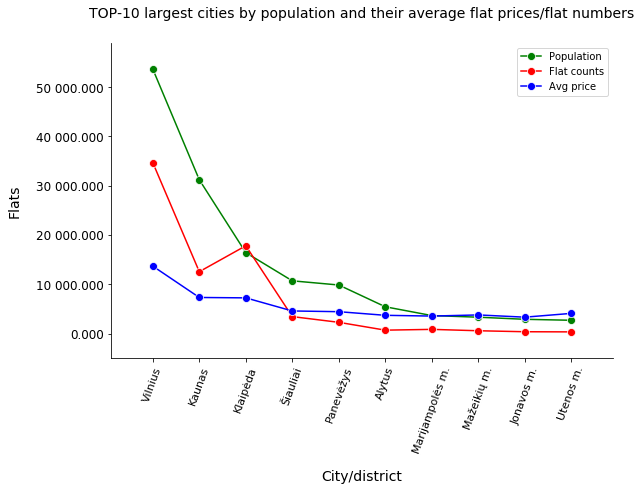

In [21]:
vilniusCityCount = flatsSale.groupby("City")
columns = ["Vilnius", "Kaunas", "Klaipėda", "Šiauliai", "Panevėžys", 
           "Alytus", "Marijampolės m.", "Mažeikių m.", "Jonavos m.", "Utenos m."]

flatMapCounts = vilniusCityCount.size()[columns]
flatMapPrices = vilniusCityCount.mean()["Price"][columns]
flatMapPop = pd.Series({"Vilnius": 536692,
                            "Kaunas": 312120,
                            "Klaipėda": 164310,
                            "Šiauliai": 107086,
                            "Panevėžys": 98598,
                            "Alytus": 54437,
                            "Marijampolės m.": 36628,
                            "Mažeikių m.": 33281,
                            "Jonavos m.": 29031,
                            "Utenos m.": 27041})

plt.figure(figsize = (9, 6))
plot1 = init_chart("line", flatMapPop / 10, "", ["", ""], "Population", ["o", "Green"])
plot2 = init_chart("line", flatMapCounts * 10, "", ["", ""], "Flat counts", ["o", "Red"])
plot3 = init_chart("line", flatMapPrices / 10, "TOP-10 largest cities by population and their average flat prices/flat numbers", ["City/district", "Flats"], "Avg price", ["o", "Blue"])
rotate_labels(70)

In [22]:
flatMapComb = pd.concat([flatMapCounts, flatMapPrices, flatMapPop], axis = 1)
flatMapComb = flatMapComb.rename({0:"Flat Count", 1: "Population"}, axis = 1)
flatMapComb.corr()

,Flat Count,Price,Population
Flat Count,1.000000,0.987163,0.943253
Price,0.987163,1.000000,0.972818
Population,0.943253,0.972818,1.000000


#### Facts that we can take from the chart & correlation above:
*    As population & flat number decreases, so does the average price.<br>
     The exception to this is the Klaipėda city.

#### Flat prices histogram
Flat prices (outliers removed) - flat prices without the outliers(less than 200 000 EUR).<br>
Flat prices (outliers not removed) - flat prices with all data(and outliers).

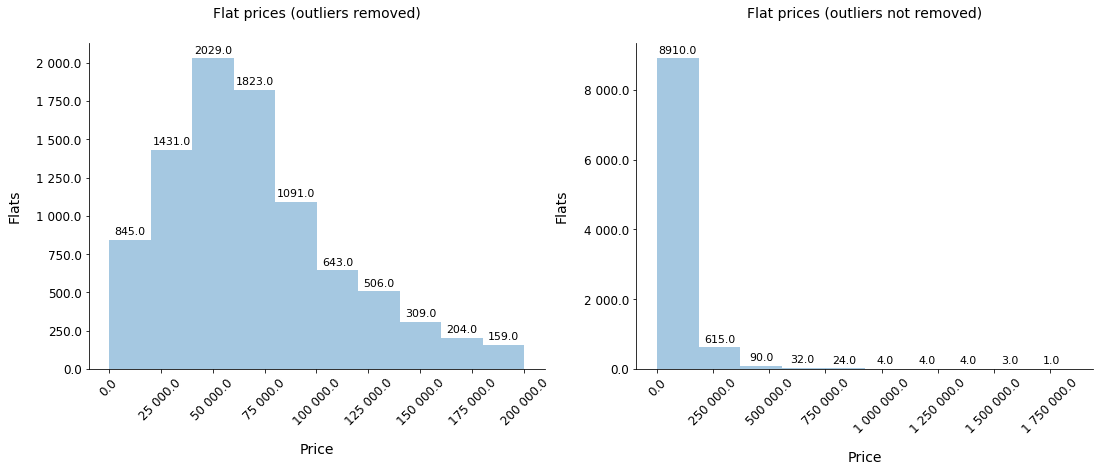

In [23]:
f, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.despine()

plot1 = sns.distplot(flatsSale["Price"], kde=False, bins=10, ax=axes[1])
plot2 = sns.distplot(flatsSale[flatsSale["Price"] <= 200000]["Price"], kde=False, bins=10, ax=axes[0])

plot1.set_title("Flat prices (outliers not removed)", pad=25, fontsize=14)
plot2.set_title("Flat prices (outliers removed)", pad=25, fontsize=14)

plot1.set(xlabel = "Price", ylabel = "Flats") 
plot2.set(xlabel = "Price", ylabel = "Flats") 

ylabels1 = ["{:,}".format(x).replace(",", " ") for x in plot1.get_yticks()]
xlabels1 = ["{:,}".format(x).replace(",", " ") for x in plot1.get_xticks()]
ylabels2 = ["{:,}".format(x).replace(",", " ") for x in plot2.get_yticks()]
xlabels2 = ["{:,}".format(x).replace(",", " ") for x in plot2.get_xticks()]

plot1.set_yticklabels(ylabels1, fontsize=12)
plot1.set_xticklabels(xlabels1, fontsize=12)
plot2.set_yticklabels(ylabels2, fontsize=12)
plot2.set_xticklabels(xlabels2, fontsize=12)

plot1.xaxis.label.set_size(14)
plot1.xaxis.labelpad = 15
plot2.xaxis.label.set_size(14)
plot2.xaxis.labelpad = 15

plot1.yaxis.label.set_size(14)
plot1.yaxis.labelpad = 15
plot2.yaxis.label.set_size(14)
plot2.yaxis.labelpad = 15

for tick in plot1.axes.get_xticklabels():
    tick.set_rotation(45)
for tick in plot2.axes.get_xticklabels():
    tick.set_rotation(45)

display_values(plot1)
display_values(plot2)

#### Facts that we can take from the chart above:
*    Most of the prices are between 0 - 200 K.
*    There are about less than 400 outliers in the right chart.

### Miscellaneous columns

#### Flats by building type

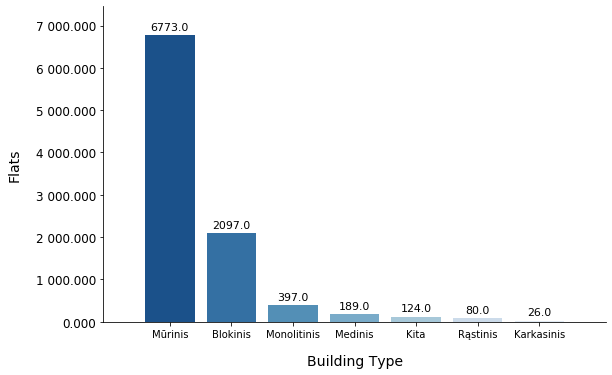

In [24]:
buildingTypes = flatsSale.groupby('BuildingType').size().sort_values(ascending=False)

plt.figure(figsize = (9, 6))
plot = init_chart("bar", buildingTypes, "", ["Building Type", "Flats"])

display_values(plot)

#### Facts that we can take from the chart above:
*    As you can see the vast majority is taken by Mūrinis, followed by Blokinis.
*    Medinis, Rąstinis and Karkasinis building types are pretty rare.

### Time

#### TOP-10 most popular construction years for flats

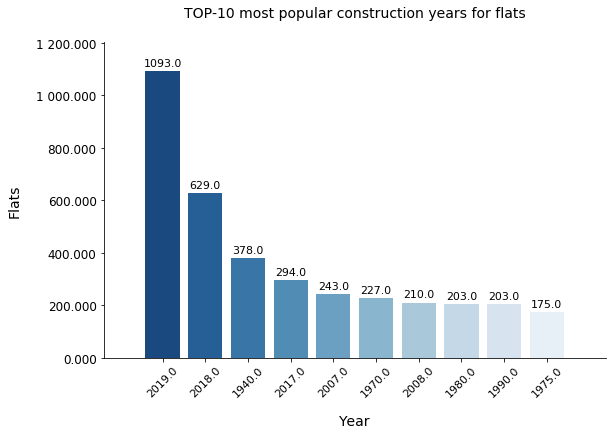

In [25]:
constructionYears = flatsSale.groupby("Year").size().reset_index()
constructionYears.columns = ["Year", "Count"]
constructionYears = constructionYears.sort_values('Count', ascending=False).iloc[:10]

plt.figure(figsize = (9, 6))
plot = init_chart("bar2", constructionYears, "TOP-10 most popular construction years for flats", 
                  ["Year","Flats"], None, None, ["Year", "Count"]) 

display_values(plot)
rotate_labels(45)

#### Facts that we can take from the chart above:
*    Out of TOP-10, half of the flats have been built in the 21st century.
*    Rest are spread out, but mostly its the late 70s, 80s and 90s<br> with an exception of 1940 - 378 flats were build during the WW2, and that is impressive!

#### Hypothesis: people upload more flat listings on the weekends

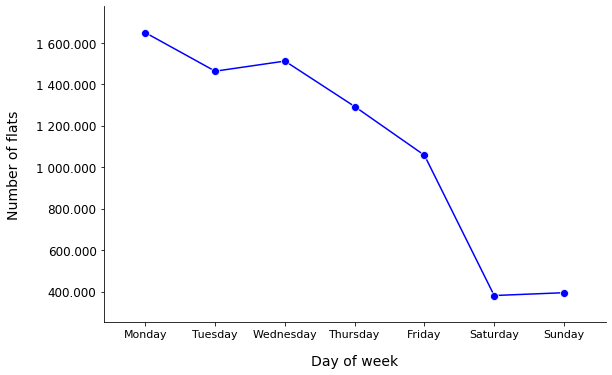

In [26]:
dayofweek = pd.DatetimeIndex(flatsSale["UploadDate"]).dayofweek.tolist()

plt.figure(figsize = (9, 6))
plot1 = init_chart("line", pd.Series({
                    "Monday": dayofweek.count(0),
                    "Tuesday": dayofweek.count(1),
                    "Wednesday": dayofweek.count(2),
                    "Thursday": dayofweek.count(3),
                    "Friday": dayofweek.count(4),
                    "Saturday": dayofweek.count(5),
                    "Sunday": dayofweek.count(6)
                  }), "", ["Day of week", "Number of flats"], "", ["o", "Blue"])
rotate_labels(0)

#### Facts that we can take from the chart above:
*   I couldn't be more wrong, it looks that the most active day of a week is the start of a week - Monday and the weekend is the least active!

### Views

### Views boxplot
I removed outliers for this chart only.<br>
Set maximum views value for this chart to be 2000.

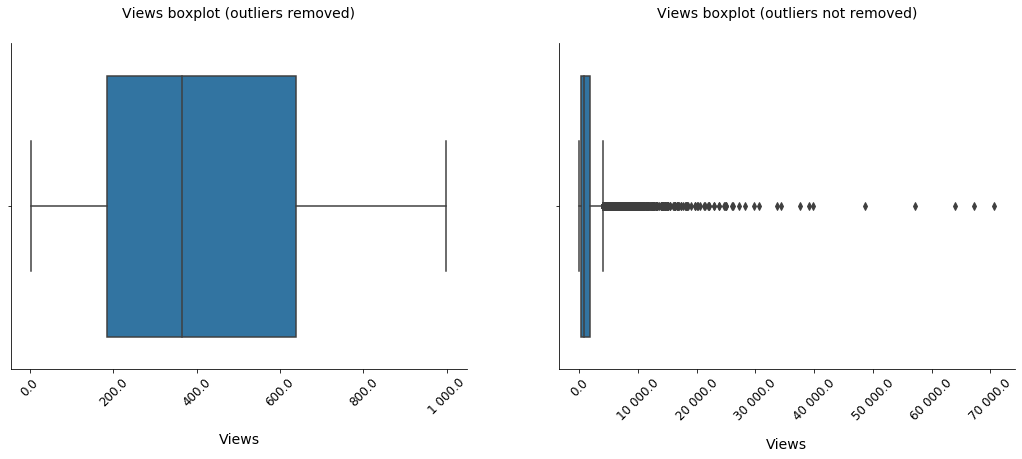

In [27]:
f, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.despine()

plot1 = sns.boxplot(x=flatsSale[flatsSale["Views"] < 1000]["Views"], ax=axes[0])
plot2 = sns.boxplot(x=flatsSale["Views"], ax=axes[1])

plot1.set_xlabel("Views", fontsize=10)
plot2.set_xlabel("Views", fontsize=10)

plot1.set_title("Views boxplot (outliers removed)", pad=25, fontsize=14)
plot2.set_title("Views boxplot (outliers not removed)", pad=25, fontsize=14)

plot1.xaxis.label.set_size(14)
plot1.xaxis.labelpad = 15
plot2.xaxis.label.set_size(14)
plot2.xaxis.labelpad = 15

xlabels1 = ["{:,}".format(x).replace(",", " ") for x in plot1.get_xticks()]
xlabels2 = ["{:,}".format(x).replace(",", " ") for x in plot2.get_xticks()]
plot1.set_xticklabels(xlabels1, fontsize=12)
plot2.set_xticklabels(xlabels2, fontsize=12)

for tick in plot1.axes.get_xticklabels():
    tick.set_rotation(45)
for tick in plot2.axes.get_xticklabels():
    tick.set_rotation(45)    

#### Facts that we can take from the chart above:
*   Most of views are concentrated between 250 and 700.
*   There are quite a few outliers as you can see on the right chart.

### TOP-5 cities by cumulative views

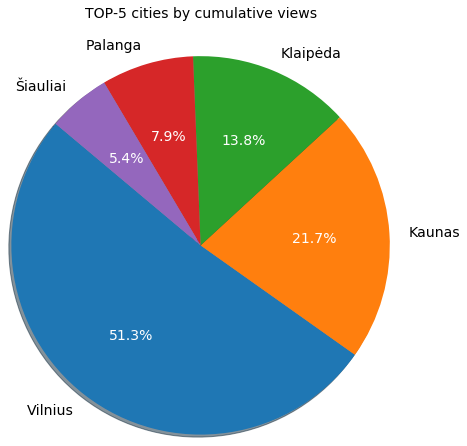

In [28]:
data = flatsSale.groupby("City")["Views"].sum().sort_values(ascending=False)[:5]
plt.figure(figsize = (9, 6))
_, _, autotexts  = init_chart("pie", data, "", ["District", "Flats"])
plt.title("TOP-5 cities by cumulative views", pad=70, fontsize=14)

set_value_label_color_pie(autotexts, "white")

#### Facts that we can take from the chart above:
*    Most of people are interested in flats in Vilnius city, followed by Kaunas & Klaipėda.
*    Quite a lot of peopel are looking for flats in Palanga.<br>Who wouldn't enjoy having a flat near the sea?

### Maps
### Flats map(whose who had coordinates)

In [29]:
"""
m = folium.Map(
    location=[54.897069, 23.903187],
    zoom_start=7.4
)

mapData = flatsSale[["Latitude", "Longitude", "Link"]].dropna()
popups = [ "<a href='" + link + "' target='_blank'>url</a>" for link in mapData["Link"].values.tolist()]

marker_cluster = MarkerCluster(
    locations=mapData[["Latitude", "Longitude"]].values.tolist(),
    popups=popups,
    overlay=True,
    control=True
)

marker_cluster.add_to(m)
folium.LayerControl().add_to(m)
m.save("map.html")
"""
IFrame(src="map.html", width=800, height=600)

#### Facts that we can take from the map above:
*    You can see that most flats(by zooming in) are concentrated in 7(I removed Curonian Split) places:(in descending order)<br>
<div>
    <table align="left">
      <tr>
        <th>City/district name</th>
      </tr>
      <tr>
        <td>Vilnius city and it's region</td>
      </tr>
      <tr>
        <td>Klaipėda city and it's region</td>
      </tr>
      <tr>
        <td>Kaunas city and it's region</td>
      </tr>
      <tr>
        <td>Palanga city and it's region</td>
      </tr>     
      <tr>
        <td>Šiauliai city and it's region</td>
      </tr>
      <tr>
        <td>Panevėžys city and it's region</td>
      </tr>
      <tr>
        <td>Druskininkai city and it's region</td>
      </tr>        
        
    </table>
</div>

### 2019-08-18 - 2019-08-24 live map of flat listings

In [30]:
"""
mapData =  flatsSale[["Latitude", "Longitude", "UploadDate"]].dropna().sort_values(by='UploadDate', ascending=True)
mapData  = mapData[mapData['UploadDate'] >= '2019-08-18']

dataLen = len(mapData)
initial_data = mapData[["Latitude", "Longitude"]].values[:dataLen]
data = [(initial_data[0:i + 1]).tolist() for i in range(dataLen)]
time_index = mapData['UploadDate'].astype(str).tolist()[:dataLen]

m = folium.Map([54.897069, 23.903187], zoom_start=7.4)

hm = plugins.HeatMapWithTime(
    data,
    index=time_index,
    max_opacity=0.3
)

hm.add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
m.save("map2.html")
"""
IFrame(src="map2.html", width=800, height=600)

*   You can see how quickly 3 major cities: Vilnius, Kaunas, Klaipėda gets the red spots.


### 378 flats were build in 1940.I want to see all flats build during WW2!

In [31]:
m = folium.Map(
    location=[54.897069, 23.903187],
    zoom_start=7.4
)

mapData = flatsSale[["Latitude", "Longitude", "Link", "Year"]].dropna()
mapData = mapData[(mapData["Year"] >= 1939) & (mapData["Year"] <= 1945)]

popups = [ "<a href='" + link + "' target='_blank'>url</a>" for link in mapData["Link"].values.tolist()]

marker_cluster = MarkerCluster(
    locations=mapData[["Latitude", "Longitude"]].values.tolist(),
    popups=popups,
    overlay=True,
    control=True
)

marker_cluster.add_to(m)
folium.LayerControl().add_to(m)
m.save("map3.html")
IFrame(src="map3.html", width=800, height=600)

#### Facts that we can take from the map above:
*   Most of flats, during WW2, were build in Vilnius.
*   In Vilnius, most of them in Vilnius Senamiestis.

### Machine learning model
#### Building type classification based on rooms, area, floor, total floors
I am using a KNN - <a href='https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm' target='_blank'>k-nearest neighbors</a> algorithm to predict **Building Type** based on these factors(values):
*   Rooms
*   Area
*   Floor
*   Total floors
*   Year

I use `n_neighbors` value of 9 because of the error chart below.

Example & tutorial can be found here: <a href='https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/' target='_blank'>URL</a>

#### Data for model:

In [32]:
# Dataframe that holds all the columns for the model.
Z = flatsSale.iloc[:,6:12].dropna()
# X - numeric values without the categorical column.
X = Z.iloc[:,:5].values
# Y - categorical column
y = Z.iloc[:,5].values

Z.head()

,Rooms,Area,Floor,TotalFloors,Year,BuildingType
0,2,38.73,3,6,2019.0,Mūrinis
1,3,83.16,3,3,2019.0,Mūrinis
2,2,49.20,1,4,2019.0,Mūrinis
3,2,49.20,2,4,2019.0,Mūrinis
4,3,65.67,1,3,2019.0,Mūrinis


In [33]:
# Initialize test & train data. 
# Set train data to 80% of the total dataframe,
# 20% for validation part.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Scale values for the model.
scaler = StandardScaler()
scaler.fit(X_train)

# Scale train data.
X_train = scaler.transform(X_train)
# Scale test data. 
X_test = scaler.transform(X_test)

# Initialize the KNN.
classifier = KNeighborsClassifier(n_neighbors=7)
# Train the KNN.
classifier.fit(X_train, y_train)

# Get the prediction results.
y_pred = classifier.predict(X_test)

#### Model results:

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Blokinis       0.63      0.65      0.64       399
  Karkasinis       0.00      0.00      0.00         4
        Kita       0.47      0.27      0.34        26
     Medinis       0.45      0.32      0.37        41
 Monolitinis       0.60      0.29      0.39        85
     Mūrinis       0.82      0.87      0.84      1359
    Rąstinis       0.33      0.06      0.10        18

    accuracy                           0.77      1932
   macro avg       0.47      0.35      0.38      1932
weighted avg       0.75      0.77      0.76      1932



It's hard to say definetly, since it's my 1/2 ML model and I don't have the knowledge to interpret it much, catch mistakes and etc, but here you go:
#### Facts that we can take from the chart above:
*    It predicts Mūrinis type pretty well, since this type occupies 71% of the data.
*    2nd place goes to Blokinis.
*    Both Mūrinis and Blokinis types are pretty steady, their values don't vary that greatly(after each re-run) compared to other ones.
*    I can't say much about other types, since numbers varies highly.

#### Error Rate with the K Value

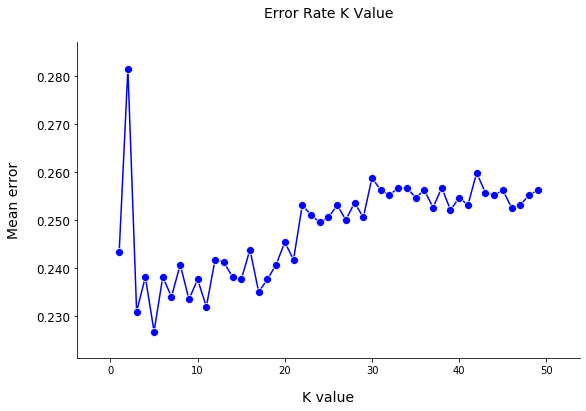

In [35]:
error = []

# Calculating error for K values between 1 and 50.
for i in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

errorSeries = pd.Series(error)
# Start from 1 instead of 0.
errorSeries.index += 1

plt.figure(figsize = (9, 6))
plot = init_chart("line", errorSeries, "Error Rate K Value", ["K value", "Mean error"], "", ["o", "Blue"])